<b>environment:</b> squidpy_env, python=3.9.23

In [28]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import scipy.sparse as sp
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import networkx as nx
import seaborn as sns

import os
from pathlib import Path 

# set path to CellPhoneDB files
CCC_path = '/Users/nabilazulkapeli/Documents/Honours Thesis 2025/nabs_data/CCC'
CCC_path = Path(CCC_path)

import re

from filter_adata import adata_filtered, adata_hightumour, adata_peritumour 
from differential_expression import run_DEG_wilcoxon
from nhood_per_core import make_spatial_neighbors_per_core
from starbars import starbars

In [44]:
# wrapper functions for neighbourhood analysis
def parse_pair(pair):
    """
    split LR pair string into genes.
    expand integrin complexes immediately into their subunits (from integrin_map).
    """
    pair = pair.replace("_complex", "")  # strip suffix
    parts = pair.split("_")
    
    # glue "integrin" + next token back together
    merged = []
    skip_next = False
    for i, p in enumerate(parts):
        if skip_next:
            skip_next = False
            continue
        if p == "integrin" and i+1 < len(parts):
            merged.append("integrin_" + parts[i+1])
            skip_next = True
        else:
            merged.append(p)
    
    # expand integrins into subunits
    expanded = []
    for g in merged:
        if g in integrin_map:
            expanded.extend(integrin_map[g])
        else:
            expanded.append(g)
    
    return expanded

def compute_enrichment_per_sample(adata, sample_col=None):
    results = {}
    for sample, ad in adata.obs.groupby(sample_col):
        sub = adata[adata.obs[sample_col] == sample].copy()
        sq.gr.nhood_enrichment(sub, cluster_key="specific_cell_types")
        results[sample] = pd.DataFrame(
            sub.uns["specific_cell_types_nhood_enrichment"]["zscore"],
            index=sub.obs["specific_cell_types"].cat.categories,
            columns=sub.obs["specific_cell_types"].cat.categories,
        )
    return results

def stack_results(results_dict):
    out = []
    for pid, df in results_dict.items():
        long = df.stack().reset_index()
        long.columns = ["lig_cell", "rec_cell", "zscore"]
        long["patient_id"] = pid
        out.append(long)
    return pd.concat(out, ignore_index=True)

def plot_spatial_niche(adata, core_id, niche_types, size=5):
    coords = adata.obsm["spatial"]
    df = adata.obs.copy()
    df["x"] = coords[:, 0]
    df["y"] = coords[:, 1]

    # select just this core
    core_df = df[df["core_id"] == core_id]

    # split into niche vs background
    niche_df = core_df[core_df["specific_cell_types_mapped"].isin(niche_types)]
    bg_df    = core_df[~core_df["specific_cell_types_mapped"].isin(niche_types)]

    plt.figure(figsize=(6, 6))

    # 1) plot background in gray
    sns.scatterplot(
        data=bg_df,
        x="x", y="y",
        color="gray",
        s=size,
        linewidth=0,
        alpha=0.5
    )

    # 2) overlay niche cells in color
    ax = sns.scatterplot(
        data=niche_df,
        x="x", y="y",
        hue="specific_cell_types_mapped",
        s=30,
        linewidth=0.5,
        palette=forest_colors,
        edgecolors="black",
    )

    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title({core_id})

    # filter legend to show only selected types
    handles, labels = ax.get_legend_handles_labels()
    filtered = [(h, l) for h, l in zip(handles, labels) if l in legend_subset]
    if filtered:
        handles, labels = zip(*filtered)
        leg = ax.legend(handles, labels, ncols=3, loc='upper center', bbox_to_anchor=(0.5,-.01))
        for handle in leg.legend_handles:
            try:
                handle.set_sizes([10])        # PathCollection
            except AttributeError:
                handle.set_markersize(10)      # Line2D
    plt.show()

In [ ]:
# dictionaries for colours and new labels
forest_colors = {
    "Melanoma": "#b0b0b0",
    "Endothelial": "#7C3C67",
    "Epithelial": "#AF5A93",
    "cCAF": "#BD75A5",
    "iCAF": "#CA91B7",
    "Mast": "#4B3D80",
    "Granulocyte": "#67589B",
    "Dendritic": "#264566",
    "M1 TAM": "#496F97",
    "M2 TAM": "#5B83AE",
    "Ig-TAM": "#7697BC",
    "Plasmablast": "#3E7682",
    "Plasma": "#4D99A8",
    "TLS": "#65AAB8",
    "CD4 T": "#81BAC5",
    "CD8 T": "#ABD1D8"
}

labels_map = {
    "Proliferating Melanoma": "Melanoma",
    "Endothelial": "Endothelial",
    "Epithelial": "Epithelial",
    "Classical CAF": "cCAF",
    "Inflammatory CAF": "iCAF",
    "Mast": "Mast",
    "Granulocyte": "Granulocyte",
    "Dendritic": "Dendritic",
    "M1 TAM": "M1 TAM",
    "M2 TAM": "M2 TAM",
    "Ig-expressing TAM": "Ig-TAM",
    "Plasmablast": "Plasmablast",
    "Plasma B": "Plasma",
    "TLS": "TLS",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T"
}

<h1><b>High Tumour Analysis

Running DEG on each cell type...
Wilcoxon rank-sum test successful for Proliferating Melanoma!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Granulocyte!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Epithelial!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Inflammatory CAF!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Endothelial!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for CD8 T!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for M2 TAM!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Classical CAF!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Plasmablast!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for Dendritic!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for M1 TAM!
Running DEG on each cell type...
Wilcoxon rank-sum test successful for CD4 T!

  0%|          | 0/1000 [00:00<?, ?/s]/opt/anaconda3/envs/squidpy_env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
  0%|          | 0/100 [00:00<?, ?/s]/opt/anaconda3/envs/squidpy_env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
  0%|          | 0/1000 [00:00<?, ?/s]/opt/anaconda3/envs/squidpy_env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
100%|██████████| 1000/1000 [00:09<00:00, 110.75/s]
/opt/anaconda3/envs/squidpy_env/lib/python3.9/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing v

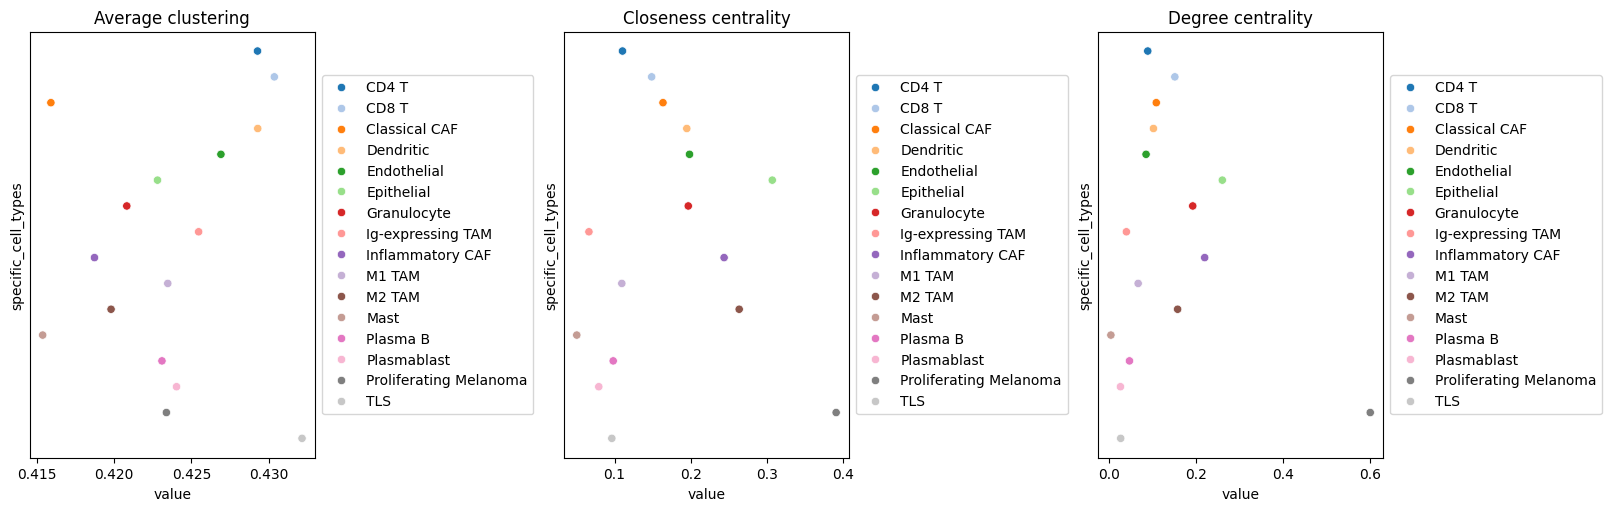

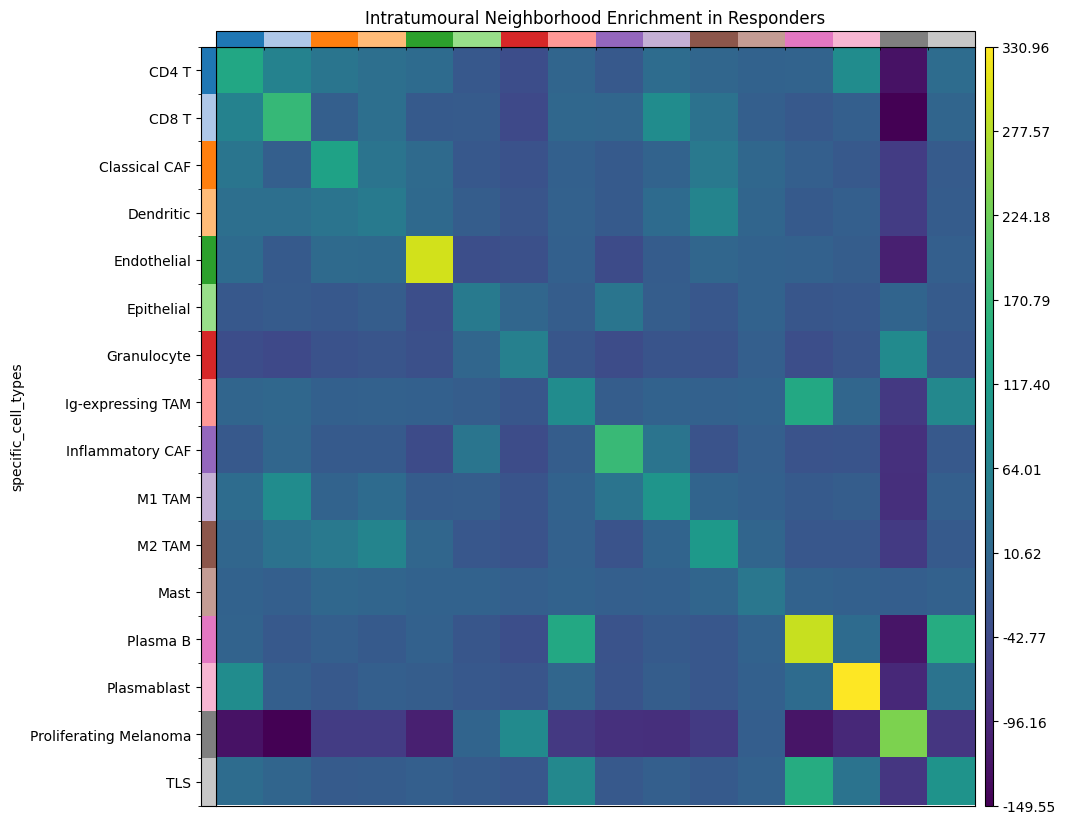

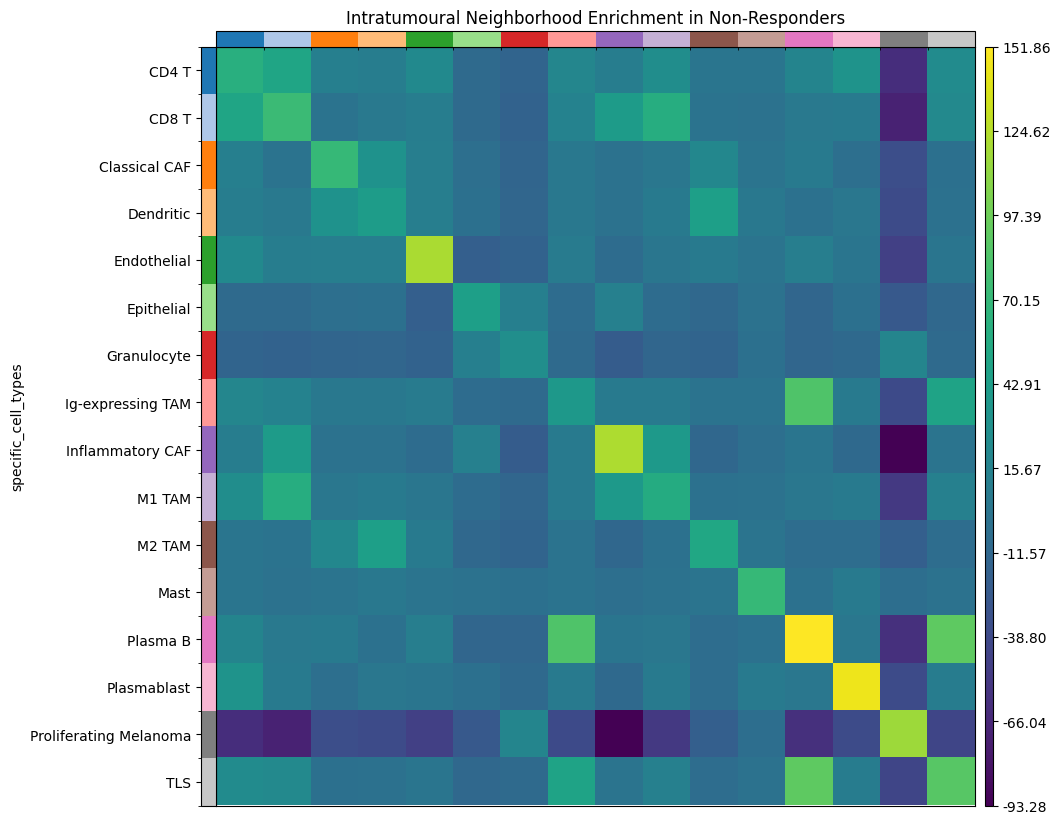

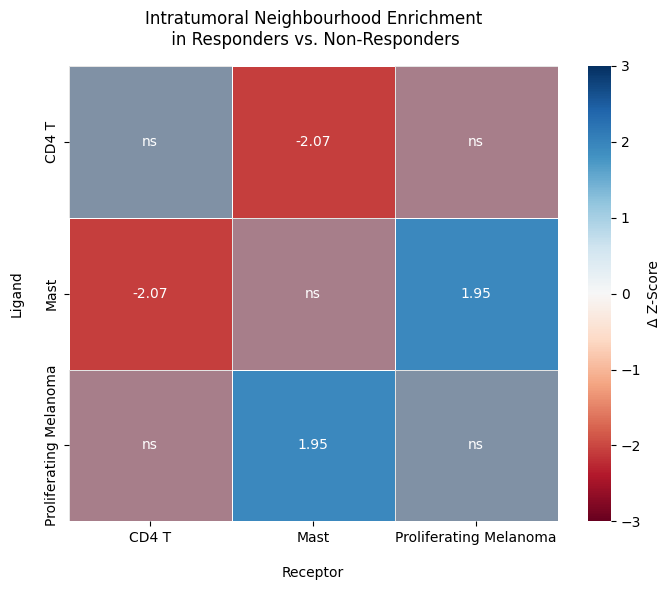

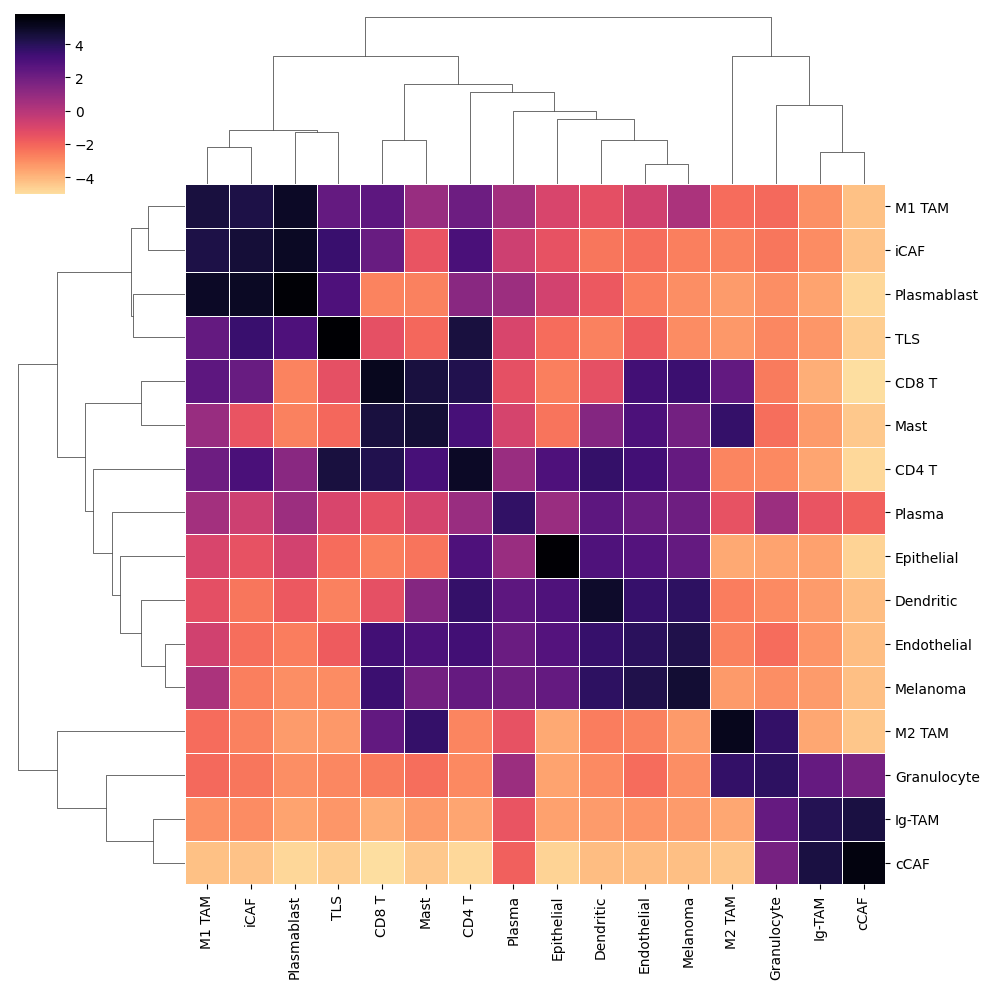

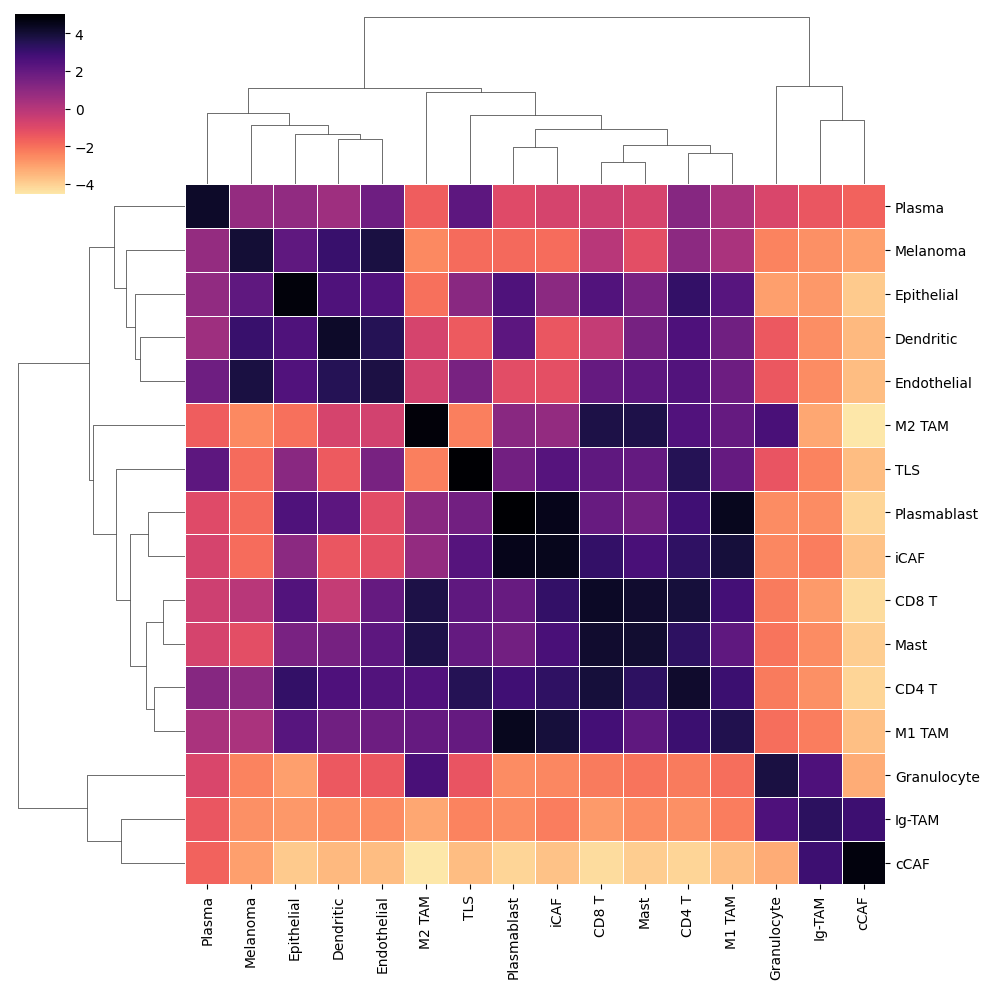

In [40]:
# grab DEG list
ht_DEG = run_DEG_wilcoxon(
    adata=adata_hightumour,
    response_col='Response',
    celltype_col='specific_cell_types'
)

# neighbourhood enrichment PER CORE
sq_adata_ht = make_spatial_neighbors_per_core(adata_hightumour, group_key="core_id", delaunay=True)
sq_adata_ht.obs['specific_cell_types'] = sq_adata_ht.obs['specific_cell_types'].astype('category')
sq.gr.centrality_scores(sq_adata_ht, cluster_key='specific_cell_types')
sq.pl.centrality_scores(sq_adata_ht, cluster_key="specific_cell_types", figsize=(16, 5))
sq.gr.nhood_enrichment(sq_adata_ht, cluster_key="specific_cell_types")

ht_sig_DEGs = ht_DEG.sort_values("qval").head(40)["gene"].drop_duplicates().tolist()
sq.gr.spatial_autocorr(
    sq_adata_ht,
    mode="moran",
    genes=ht_sig_DEGs,
    n_perms=100,
    n_jobs=1,
)

# responders vs. non-responders analysis
sq_ht_R = sq_adata_ht[sq_adata_ht.obs.Response=='Responder']
sq_ht_NR = sq_adata_ht[sq_adata_ht.obs.Response=='Non-Responder']

# responders
sq.gr.nhood_enrichment(sq_ht_R, cluster_key="specific_cell_types")
sq.pl.nhood_enrichment(
    sq_ht_R,
    cluster_key="specific_cell_types",
    figsize=(8, 8),
    title="Intratumoural Neighborhood Enrichment in Responders",
)
sq.gr.centrality_scores(sq_ht_R, cluster_key='specific_cell_types')

# non-responders
sq.gr.nhood_enrichment(sq_ht_NR, cluster_key="specific_cell_types")
sq.pl.nhood_enrichment(
    sq_ht_NR,
    cluster_key="specific_cell_types",
    figsize=(8, 8),
    title="Intratumoural Neighborhood Enrichment in Non-Responders",
)
sq.gr.centrality_scores(sq_ht_NR, cluster_key='specific_cell_types')

# load means and pvals
means_R = pd.read_csv(os.path.join(CCC_path, "ht", "R", "statistical_analysis_means_09_05_2025_153947.txt"), sep="\t")
means_NR = pd.read_csv(os.path.join(CCC_path, "ht", "NR", "statistical_analysis_means_09_05_2025_154135.txt"), sep="\t")
pvals_R = pd.read_csv(os.path.join(CCC_path, 'ht', 'R', 'statistical_analysis_pvalues_09_05_2025_153947.txt'), sep='\t')
pvals_NR = pd.read_csv(os.path.join(CCC_path, 'ht', 'NR', 'statistical_analysis_pvalues_09_05_2025_154135.txt'), sep='\t')

# set index for means tables
means_R = means_R.set_index("interacting_pair")
means_NR = means_NR.set_index("interacting_pair")

# get rid of core names (cell1::cell2 -> cell1|cell2)
means_R.columns = [col.split("::")[0] if "::" in col else col for col in means_R.columns]
means_NR.columns = [col.split("::")[0] if "::" in col else col for col in means_NR.columns]

# convert to numeric
means_R = means_R.select_dtypes(include=[np.number])
means_NR = means_NR.select_dtypes(include=[np.number])

# align R/NR
means_R, means_NR = means_R.align(means_NR, join="inner", axis=1)

# subtraction
diff_means = means_R - means_NR
interaction_diffs = diff_means.abs().max(axis=1).sort_values(ascending=False)

# top 20 interaction pairs
top20_pairs = interaction_diffs.head(20).index

# map genes to cell types
gene_to_cell = (
    ht_DEG.groupby("gene")["cell_type"]
    .apply(lambda x: list(x.unique()))
    .to_dict()
)

# map integrin complex labels to gene labels
integrin_map = {
    "integrin_aXb2": ["ITGAX"],
    "integrin_aMb2": ["ITGAM"],
    "integrin_aLb2": ["ITGAL"],
}

lr_mapping = {}

for pair in top20_pairs:
    genes = parse_pair(pair)
    cell_types = []
    for g in genes:
        if g in gene_to_cell:
            cell_types.append(gene_to_cell[g])
        else:
            cell_types.append(["Unknown"])
    lr_mapping[pair] = cell_types

enrich_df = pd.DataFrame(
    sq_adata_ht.uns["specific_cell_types_nhood_enrichment"]["zscore"],
    index=sq_adata_ht.obs["specific_cell_types"].cat.categories,
    columns=sq_adata_ht.obs["specific_cell_types"].cat.categories,
)

R_results = compute_enrichment_per_sample(sq_ht_R, sample_col="Melpin")
R_long = stack_results(R_results)
R_long["group"] = "R"

NR_results = compute_enrichment_per_sample(sq_ht_NR, sample_col="Melpin")
NR_long = stack_results(NR_results)
NR_long["group"] = "NR"

all_enrich_df = pd.concat([R_long, NR_long])

pairs = all_enrich_df[["lig_cell","rec_cell"]].drop_duplicates()

results = []
n_perm = 1000  # increase for robustness

for _, row in pairs.iterrows():
    lig, rec = row["lig_cell"], row["rec_cell"]
    sub = all_enrich_df.query("lig_cell == @lig and rec_cell == @rec")
    
    z_R = sub.loc[sub["group"]=="R", "zscore"].mean()
    z_NR = sub.loc[sub["group"]=="NR", "zscore"].mean()
    obs_diff = z_R - z_NR
    
    # permutation test
    null_diffs = []
    for _ in range(n_perm):
        shuffled = sub["group"].sample(frac=1, replace=False).values
        null_R = sub.loc[shuffled=="R", "zscore"].mean()
        null_NR = sub.loc[shuffled=="NR", "zscore"].mean()
        null_diffs.append(null_R - null_NR)
    
    null_diffs = np.array(null_diffs)
    # two-sided p-value
    pval = (np.abs(null_diffs) >= np.abs(obs_diff)).mean()
    
    results.append({
        "lig_cell": lig,
        "rec_cell": rec,
        "obs_diff": obs_diff,
        "pval": pval
    })

ht_diff_df = pd.DataFrame(results)
ht_diff_df["pval_adj"] = multipletests(ht_diff_df["pval"], method="fdr_bh")[1]

# focused heatmap
focus_cells = ["Mast", "Proliferating Melanoma", "CD4 T"]

# filter rows and columns to only the focus cells
heatmap_df = (
    ht_diff_df
    .query("lig_cell in @focus_cells and rec_cell in @focus_cells")
    .pivot(index="lig_cell", columns="rec_cell", values="obs_diff")
)

pval_df = (
    ht_diff_df
    .query("lig_cell in @focus_cells and rec_cell in @focus_cells")
    .pivot(index="lig_cell", columns="rec_cell", values="pval")
)

# significance mask
mask_ns = pval_df > 0.05

# annotation matrix (values + "ns")
annot = heatmap_df.round(2).astype(str)
annot[mask_ns] = "ns"

plt.figure(figsize=(7,6))
ax = sns.heatmap(
    heatmap_df,
    cmap="RdBu", center=0,
    annot=annot, fmt="",
    linewidths=0.5,
    vmin=-3, vmax=3,
    cbar_kws={"label": "Δ Z-Score"}
)

# overlay grey patches for ns
for i in range(heatmap_df.shape[0]):
    for j in range(heatmap_df.shape[1]):
        if mask_ns.iloc[i, j]:
            ax.add_patch(plt.Rectangle(
                (j, i), 1, 1,
                fill=True, color="lightgrey", ec="lightgrey", lw=0, alpha=0.6
            ))

plt.title("Intratumoral Neighbourhood Enrichment\n in Responders vs. Non-Responders", pad=15)
plt.xlabel("Receptor", labelpad=15)
plt.ylabel("Ligand", labelpad=15)
plt.tight_layout()
plt.show()


# convert to string before mapping
sq_ht_R.obs["specific_cell_types_mapped"] = (
    sq_ht_R.obs["specific_cell_types"].astype(str).map(labels_map)
)

# keep original labels if not in labels_map
sq_ht_R.obs["specific_cell_types_mapped"] = sq_ht_R.obs["specific_cell_types_mapped"].fillna(
    sq_ht_R.obs["specific_cell_types"].astype(str)
)

# (optional) convert back to categorical with clean categories
sq_ht_R.obs["specific_cell_types_mapped"] = pd.Categorical(
    sq_ht_R.obs["specific_cell_types_mapped"]
)

# convert to string before mapping
sq_ht_NR.obs["specific_cell_types_mapped"] = (
    sq_ht_NR.obs["specific_cell_types"].astype(str).map(labels_map)
)

# keep original labels if not in labels_map
sq_ht_NR.obs["specific_cell_types_mapped"] = sq_ht_NR.obs["specific_cell_types_mapped"].fillna(
    sq_ht_NR.obs["specific_cell_types"].astype(str)
)

# (optional) convert back to categorical with clean categories
sq_ht_NR.obs["specific_cell_types_mapped"] = pd.Categorical(
    sq_ht_NR.obs["specific_cell_types_mapped"]
)

enrich_R  = sq_ht_R.uns["specific_cell_types_nhood_enrichment"]
enrich_NR = sq_ht_NR.uns["specific_cell_types_nhood_enrichment"]

enrich_R_df = enrich_R["zscore"]
enrich_NR_df = enrich_NR["zscore"]

zscores_log_R = np.sign(enrich_R_df) * np.log1p(np.abs(enrich_R_df))
zscores_log_NR = np.sign(enrich_NR_df) * np.log1p(np.abs(enrich_NR_df))

cell_types = sq_ht_R.obs["specific_cell_types_mapped"].cat.categories
zscores_df = pd.DataFrame(zscores_log_R, index=cell_types, columns=cell_types)

sns.clustermap(
    zscores_df,
    cmap="magma_r",
    center=0,
    figsize=(10,10),
    linewidths=0.5,   # add grid lines
    annot=False       # or True if you want numbers inside cells
)

zscores_df_NR = pd.DataFrame(zscores_log_NR, index=cell_types, columns=cell_types)

sns.clustermap(
    zscores_df_NR,
    cmap="magma_r",
    center=0,
    figsize=(10,10),
    linewidths=0.5,   # add grid lines
    annot=False,       # or True if you want numbers inside cells.
)

# responder niches
# run clustering on the enrichment matrix
linkage = sch.linkage(zscores_df, method="average")
clusters = sch.fcluster(linkage, t=10, criterion="distance")

# map cluster back to cell types to find niches
niche_assignments_HT_R = pd.Series(clusters, index=zscores_df.index)

# non-responder niches
# run clustering on the enrichment matrix
linkage_NR = sch.linkage(zscores_df_NR, method="average")
clusters_NR = sch.fcluster(linkage_NR, t=10, criterion="distance")

# map cluster back to cell types to find niches
niche_assignments_HT_NR = pd.Series(clusters_NR, index=zscores_df_NR.index)

# look at niche_assignments_HT_R and niche_assignments_HT_NR to see niche assignments

<h2><b>Spatial Plots for Niches

In [ ]:
ht_niche_immune = ['M1 TAM', 'Plasmablast', 'TLS', 'iCAF']
legend_subset = ['M1 TAM', 'Plasmablast', 'TLS', 'iCAF']

for core in sq_ht_R.obs["core_id"].unique():
    plot_spatial_niche(sq_ht_R, core, ht_niche_immune)

In [ ]:
ht_niche_stromal = ['Dendritic', 'Endothelial', 'Epithelial', 'Melanoma', 'Plasma']
legend_subset = ['Dendritic', 'Endothelial', 'Epithelial', 'Melanoma', 'Plasma']

for core in sq_ht_R.obs["core_id"].unique():
    plot_spatial_niche(sq_ht_R, core, ht_niche_stromal)

In [ ]:
ht_mixed_niche = ['CD4 T', 'CD8 T', 'M1 TAM', 'Mast', 'Plasmablast', 'Plasma', 'iCAF', 'TLS']
legend_subset = ['CD4 T', 'CD8 T', 'M1 TAM', 'Mast', 'Plasmablast', 'Plasma', 'iCAF', 'TLS']

for core in sq_ht_NR.obs["core_id"].unique():
    plot_spatial_niche(sq_ht_NR, core, ht_mixed_niche)